In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

import prepare
import acquire
#import wrangle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# import prepare
df = acquire.run()
df = prepare.prepare_data(df)
train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split(df, 'tract_cases_per_100k')

Acquire: compiling raw data files...
Acquire: Completed!


In [3]:
train_exp.shape

(216, 26)

In [4]:
df.shape

(362, 26)

In [5]:
train_exp.head()

,tract,raw_svi,f_pov_soci,f_unemp_soci,f_pci_soci,f_nohsdp_soci,f_soci_total,f_age65_comp,f_age17_comp,f_disabl_comp,...,f_mobile_trans,f_crowd_trans,f_noveh_trans,f_groupq_trans,f_trans_total,all_flags_total,zip,tract_cases_per_100k,bin_svi,rank_svi
234,48029180701,0.4841,0,0,0,0,0,0,0,0,...,0,0,0,1,2,2,78229,3423.833935,low_mod,3
3,48029110600,0.9841,1,1,1,1,4,0,0,1,...,0,0,1,1,3,8,78207,5524.052466,high,1
182,48029170600,0.7993,0,0,0,0,0,0,0,0,...,0,0,1,0,1,2,78228,4515.654482,high,1
204,48029171914,0.3723,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,78245,3627.254463,low_mod,3
277,48029181731,0.3020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,78250,2818.961625,low_mod,3


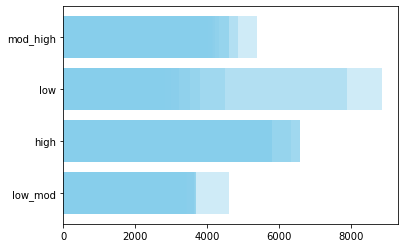

In [14]:
# create data
y= train_exp.tract_cases_per_100k
x= train_exp.bin_svi
 
# Change the color and its transparency
plt.barh( x, y, color="skyblue", alpha=0.4)
plt.show()
 